In [1]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
# Render the figure in a notebook:
%matplotlib inline  

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree

from sklearn import metrics

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F

from torchmetrics.classification import Accuracy
from torchmetrics.classification import Recall
from torchmetrics import R2Score
from torchmetrics import MeanAbsoluteError

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
x_train = pd.read_csv('../no_nontoxic_nans_X_train.csv')
y_train = pd.read_csv('../no_nontoxic_nans_y_train.csv')

x_val = pd.read_csv('../no_nontoxic_nans_X_val.csv')
y_val = pd.read_csv('../no_nontoxic_nans_y_val.csv')

x_test = pd.read_csv('../no_nontoxic_nans_x_test.csv')
y_test = pd.read_csv('../no_nontoxic_nans_y_test.csv')

In [3]:
DTC_gini = DecisionTreeClassifier(criterion='gini', max_depth=10)
def get_model_matrics(x_data,y_data,model):
    DTC_gini_pred = DTC_gini.predict(x_data.drop(columns='Unnamed: 0'))
    DTC_gini_acc = metrics.accuracy_score(y_data.drop(columns='Unnamed: 0'), DTC_gini_pred)
    print('accuracy:', DTC_gini_acc)

DTC_gini.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0'))
get_model_matrics(x_train, y_train, DTC_gini)
get_model_matrics(x_val,y_val,DTC_gini)
get_model_matrics(x_test,y_test, DTC_gini)

accuracy: 0.915740991601192
accuracy: 0.76010101010101
accuracy: 0.7449494949494949


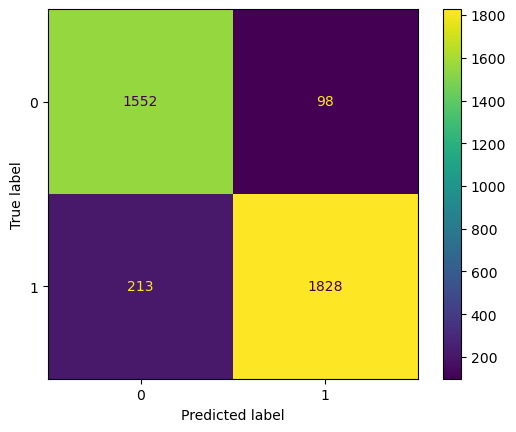

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
DTC_gini_y_pred = DTC_gini.predict(x_train.drop(columns='Unnamed: 0'))
ConfusionMatrixDisplay.from_predictions(y_train.drop(columns='Unnamed: 0'),DTC_gini_y_pred)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


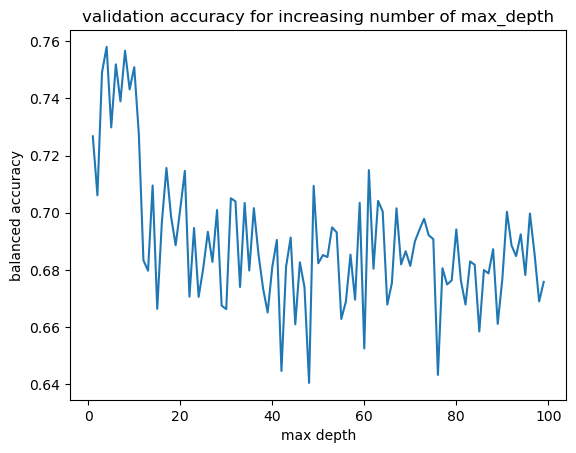

In [5]:
#learning curve
acc_list = []
i_list = []
for i in range(1,100): #number of iterations:
    print(i)
    DTC_gini_i = DecisionTreeClassifier(criterion='gini', max_depth=i) #new GINI model with i learning depth
    DTC_gini_i.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0')) #fit the model to training data.
    
    DTC_gini_pred_val = DTC_gini_i.predict(x_val.drop(columns='Unnamed: 0'))
    DTC_gini_acc_val = metrics.balanced_accuracy_score(y_val.drop(columns='Unnamed: 0'), DTC_gini_pred_val)
    acc_list.append(DTC_gini_acc_val)
    i_list.append(i)
plt.plot(i_list, acc_list)
plt.title('validation accuracy for increasing number of max_depth')
plt.xlabel('max depth')
plt.ylabel('balanced accuracy')
plt.show()


# DTC_gini.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0'))
# get_model_metrics(x_train, y_train, DTC_gini)
# get_model_metrics(x_val,y_val,DTC_gini)

In [6]:
for i in i_list:
    print(i, acc_list[i-1])
    #i = 10 is the best!

1 0.7267197140056507
2 0.7060773799227353
3 0.7490918526206538
4 0.7579715158853716
5 0.7298333621634088
6 0.7518883699475293
7 0.738943666032405
8 0.7566453324107709
9 0.7431240269849506
10 0.7508793173038113
11 0.7274981260450902
12 0.6833592804013147
13 0.6797266908839301
14 0.7095369889869112
15 0.6663783659113187
16 0.696563454996252
17 0.7156489650002883
18 0.6987257106613619
19 0.6886351842241827
20 0.7012627573084241
21 0.7146110822810356
22 0.6706452170904689
23 0.6946606700109554
24 0.6705875569393992
25 0.6806204232255089
26 0.6933344865363548
27 0.6828115089661535
28 0.7009167964020065
29 0.6675027388571758
30 0.6662918756847143
31 0.7050394972034827
32 0.7039727844086952
33 0.6740183359280401
34 0.703425012973534
35 0.6797843510349997
36 0.7016087182148417
37 0.6855503661419593
38 0.6735570547194834
39 0.6651098425877876
40 0.6809952142074612
41 0.6904803090584097
42 0.644640488958081
43 0.6811105345096005
44 0.6913163812489189
45 0.6609871417863116
46 0.6826673585884795
4

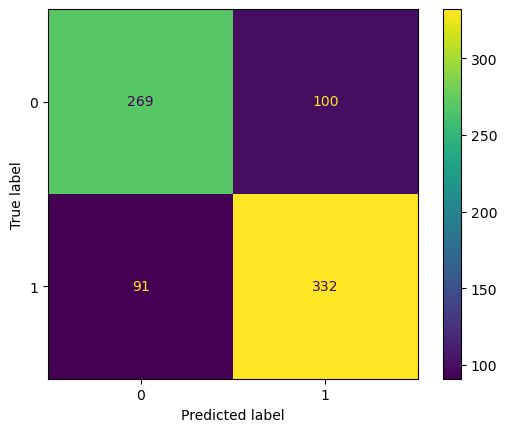

In [7]:
DTC_gini_10 = DecisionTreeClassifier(criterion='gini', max_depth=10) #new GINI model with i learning depth
DTC_gini_10.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0'))
ConfusionMatrixDisplay.from_predictions(y_val.drop(columns='Unnamed: 0'),DTC_gini_10.predict(x_val.drop(columns='Unnamed: 0')))

this isn't great. Who knows?

In [8]:
#find the recall and F1 score to present.
DTC_gini_10_test_pred = DTC_gini_10.predict(x_test.drop(columns='Unnamed: 0'))
DTC_gini_10_test_pred_f1 = metrics.f1_score(y_test.drop(columns='Unnamed: 0'), DTC_gini_pred_val)
DTC_gini_10_test_pred_recall = metrics.balanced_accuracy_score(y_test.drop(columns='Unnamed: 0'), DTC_gini_pred_val)

In [9]:
print(f'recall test {DTC_gini_10_test_pred_recall}')
print(f'f1 test {DTC_gini_10_test_pred_f1}')

recall test 0.4947150735294118
f1 test 0.5061728395061729


Text(0.5, 1.0, 'confusion matrix for 10 depth, on test data')

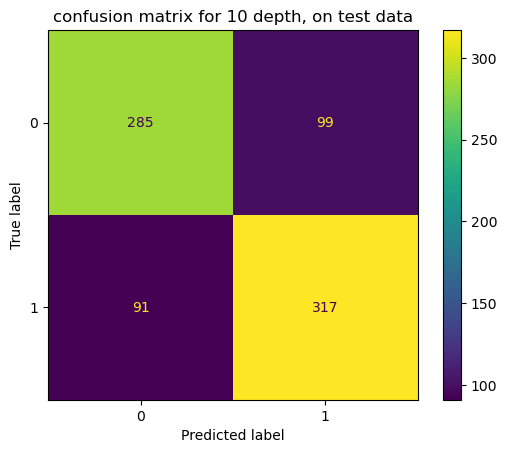

In [10]:
ConfusionMatrixDisplay.from_predictions(y_test.drop(columns='Unnamed: 0'),DTC_gini_10.predict(x_test.drop(columns='Unnamed: 0')))
plt.title('confusion matrix for 10 depth, on test data')

# More hyperparameter tuning

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error


In [48]:
param_grid = {
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tuning_DTC = DecisionTreeClassifier(random_state=0)
grid_search = GridSearchCV(estimator=tuning_DTC, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='balanced_accuracy')

grid_search.fit(x_train, y_train)
best_dtree_reg = grid_search.best_estimator_ # Get the best estimator from the grid search
y_pred = best_dtree_reg.predict(x_test)
bacc = metrics.balanced_accuracy_score(y_test, y_pred)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"bacc: {bacc}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits


KeyboardInterrupt: 

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test RMSE: 1483.7467205719718

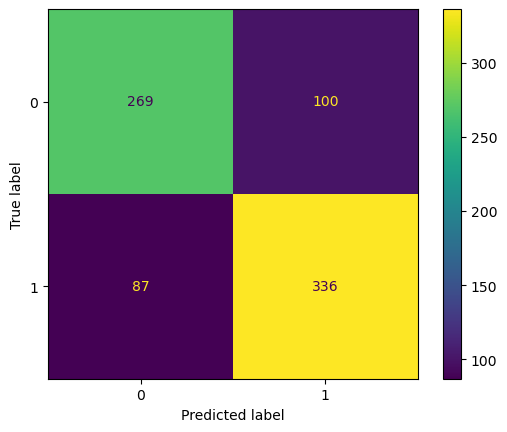

In [11]:
DTC_gini_best = DecisionTreeClassifier(criterion='gini', max_depth=10,min_samples_leaf=1,min_samples_split=2) #new GINI model with i learning depth
DTC_gini_best.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0'))
ConfusionMatrixDisplay.from_predictions(y_val.drop(columns='Unnamed: 0'),DTC_gini_best.predict(x_val.drop(columns='Unnamed: 0')))

DTC_gini_best_test_pred = DTC_gini_best.predict(x_test.drop(columns='Unnamed: 0'))
DTC_gini_best_test_pred_f1 = metrics.f1_score(y_test.drop(columns='Unnamed: 0'), DTC_gini_best_test_pred)
DTC_gini_best_test_pred_bacc = metrics.balanced_accuracy_score(y_test.drop(columns='Unnamed: 0'), DTC_gini_best_test_pred)

In [23]:
def get_feature_importance(model_fitted, top_n=10, df_x_train=x_train): #need to provide a fitted model, top_n = top n features to return sorted by toxicity (default 10), df_x_train = the name of your x_train dataframe (for naming reasons). defaults to x_train
    """Returns the feature importances as a dataframe"""
    importances_permutation = model_fitted.feature_importances_
    # std = np.std([tree.feature_importances_ for tree in model_fitted.estimators_], axis=0)
    df_importances_permutation = pd.DataFrame(importances_permutation)
    df_importances_permutation['feature'] = df_x_train.drop(columns='Unnamed: 0').columns

    df_top_n_importances_permutation = df_importances_permutation.nlargest(top_n, 0)
    print(df_top_n_importances_permutation,'\n')

    df_importances_permutation_FG = df_importances_permutation[df_importances_permutation['feature'].str.contains("fr_")] #new df containing only the features called fr_, i.e. the functional groups
    df_importances_permutation_FG_top_10 = df_importances_permutation_FG.nlargest(top_n,0)
    print(df_importances_permutation_FG_top_10)

In [24]:
get_feature_importance(DTC_gini_best)

            0         feature
28   0.238762         BertzCT
130  0.075113         MolLogP
7    0.038309  HeavyAtomMolWt
105  0.037723    FractionCSP3
4    0.031077             qed
22   0.022096   BCUT2D_LOGPHI
18   0.020800     BCUT2D_MWHI
26   0.017901          AvgIpc
21   0.017740    BCUT2D_CHGLO
83   0.017389            TPSA 

            0                 feature
135  0.009996                  fr_ArN
215  0.009457        fr_unbrch_alkane
197  0.007174               fr_phenol
144  0.007027                  fr_C_S
198  0.004124  fr_phenol_noOrthoHbond
168  0.003552             fr_bicyclic
134  0.002814         fr_Al_OH_noTert
152  0.002345       fr_Ndealkylation2
196  0.002253   fr_para_hydroxylation
133  0.001666                fr_Al_OH
